In [1]:
CALCULATE = False

In [2]:
import numpy as np
np.set_printoptions(suppress=True, formatter={'float': '{:.8f}'.format}, precision=8, linewidth=200)
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from matplotlib import pyplot as plt
plt.style.use('default')
import pandas
import seaborn as sns
from taskspec.utils_2 import N_sample, ker_eps_rho, n_dim_u, n_dim, datapath, f_true, scale, X_alg, NT, Nx, bounds, Efunc_all, Egrad_all, tau, forward_map, x_ref
from taskspec.model import DenseNet, PolyModel
from taskspec.utils import find_project_root
from scipy.optimize import minimize

2025-04-30 20:58:45.363504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2025-04-30 20:58:45.363524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def weighted_mse(y_true, y_pred, sample_weight):
    mse = tf.square(y_true - y_pred)
    weighted_mse = tf.reduce_mean(mse * sample_weight)
    return weighted_mse

In [4]:
nodess = [0, 1, 2, 3, 4, 5, 8, 12, 16, 24, 32]

In [5]:
u_tmp = tf.Variable(np.zeros((Nx,NT,n_dim_u)), dtype=tf.float64) # 1*20*1 array
Efunc = lambda u: Efunc_all(u, model, x_initial, x_tracking)
Egrad = lambda u: Egrad_all(u, model, x_initial, x_tracking)

Nrand = 20
res_arr = np.zeros((10, len(nodess), Nrand,))

if CALCULATE:
    for init_id in [0, ]:
        x_tracking = x_ref[init_id][None,:,:]
        x_initial = x_tracking[0,0][None,:]
        with np.load(f'{datapath}/data/E2_ini{init_id}.npz', allow_pickle=True) as data:
            assert np.linalg.norm(x_initial - data['x_initial']) < 1e-8
            assert np.linalg.norm(x_tracking - data['x_tracking']) < 1e-8
            x_initial = data['x_initial']
            x_tracking = data['x_tracking']
            u_best = data['u_best'][None,:,None]
            x_final = data['x_final']

        # the loss the differnce between the real trajectory and the target trajectory
        x_real = forward_map(f_true, x_initial, u_best)
        xu_traj_real, x_traj_real = X_alg(f_true, x_initial, u_best)
        fu_real = f_true(xu_traj_real)
        best_traj_loss = np.sum(np.square(x_real - x_tracking))
        
        Cmin = np.sum(np.square(x_real - x_tracking)) * tau
        print('Best trajectory loss:', Cmin)
        
        for i2, nodes in enumerate(nodess): 
            for i3, randomseed in enumerate(range(Nrand)): 
                databasename = f'{datapath}/data/data/E2_dr{randomseed}.npz'
                with np.load(databasename, allow_pickle=True) as data:
                    xdata, ydata = data['xdata'], data['ydata']
                    assert xdata.shape == (N_sample, n_dim)
                    assert ydata.shape == (N_sample, 1)
                    rho_train = data['rho_train']
                    assert rho_train.shape == (N_sample, )
                    assert ker_eps_rho == data['ker_eps_rho']

                if nodes <= 5:
                    from sklearn.preprocessing import PolynomialFeatures
                    poly = PolynomialFeatures(degree=nodes + 1, include_bias=False)
                    xdata_poly = poly.fit_transform(xdata/scale)
                    pd = poly.powers_    
                    model = PolyModel(n_dim, 1, pd, scale=scale)
                else:    
                    model = DenseNet(n_dim, 1, nodes=nodes, scale=scale)
                    model.build((None, n_dim))

                outputfile = f'{datapath}/weights/weights_ts/E2_t{nodes}_{randomseed}_{init_id}.npz'
                
                with np.load(outputfile, allow_pickle=True) as data:
                    res = data['res']
                    weights1 = data['weights1']
                    u_tmp1 = data['u_tmp1']
                    weights_l3 = data['weights_l3']
                    u_l3 = data['u_l3']
                    ind_l3 = data['ind_l3']
                
                model.set_weights(weights1)
                
                assert not np.array_equal(u_l3, np.array(None, dtype=object))           
                
                with tf.GradientTape() as tape:
                    predictions = model(xdata, training=True)
                    loss = weighted_mse(ydata, predictions, 1)
                gradients = tape.gradient(loss, model.trainable_variables)
                gradientnorm = tf.linalg.global_norm(gradients).numpy()        
                print(f"Loading MSE weights                               loss {loss}   gradientnorm {gradientnorm}")
                # MSE
                result = minimize(Efunc, np.array(u_tmp1).flatten(), jac=Egrad, bounds=bounds, method='L-BFGS-B', tol=1e-10)
                u_tmp.assign(result.x[None,:,None])
                u_tmp1 = u_tmp.numpy()
                
                x_pred = forward_map(model, x_initial, u_tmp1)
                x_model = forward_map(f_true, x_initial, u_tmp1)
                C_model = np.sum(np.square(x_model - x_tracking)) * tau
                C_mse = C_model - Cmin
                
                res_arr[0, i2, i3] = C_mse
                xu_traj, x_traj = X_alg(f_true, x_initial, u_tmp1)            
                res_arr[2, i2, i3] = np.linalg.norm(model(xu_traj) - f_true(xu_traj), axis=-1).max()
                res_arr[4, i2, i3] = np.sqrt(np.sum(np.square(u_tmp1 - u_best)))
                
                model.set_weights(weights_l3)
                result = minimize(Efunc, np.array(u_l3).flatten(), jac=Egrad, bounds=bounds, method='L-BFGS-B', tol=1e-8)
                u_tmp.assign(result.x[None,:,None])
                u_tmp3 = u_tmp.numpy()
                
                assert (np.linalg.norm(u_tmp3 - u_l3)) < 0.1
                x_pred3 = forward_map(model, x_initial, u_tmp3)
                x_model3 = forward_map(f_true, x_initial, u_tmp3)
                C_model3 = np.sum(np.square(x_model3 - x_tracking)) * tau
                C_l3 = C_model3 - Cmin
                
                res_arr[1, i2, i3] = C_l3
                xu_traj, x_traj = X_alg(f_true, x_initial, u_tmp3)            
                res_arr[3, i2, i3] = np.linalg.norm(model(xu_traj) - f_true(xu_traj), axis=-1).max()
                res_arr[5, i2, i3] = np.sqrt(np.sum(np.square(u_tmp3 - u_best)))
                
                print(nodes, randomseed, 
                    np.array([C_mse, C_l3, C_l3/C_mse,]),
                    np.array([res_arr[2, i2, i3], res_arr[3, i2, i3], res_arr[3, i2, i3]/res_arr[2, i2, i3]]),
                    ind_l3, res.shape[0])
    np.savez(find_project_root() + "/examples/fig/Eg2.npz", res_arr=res_arr)
else:
    with np.load(find_project_root() + "/examples/fig/Eg2.npz", allow_pickle=True) as data:
        res_arr = data['res_arr']

2025-04-30 20:58:47.363489: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-04-30 20:58:47.374769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2025-04-30 20:58:47.375029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:51:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2025-04-30 20:58:47.375177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:8b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 8

In [6]:
nodes = 8
randomseed = 2
init_id = 0

In [7]:
databasename = f'{datapath}/data/data/E2_dr{randomseed}.npz'
with np.load(databasename, allow_pickle=True) as data:
    print("loading data from", databasename)
    xdata, ydata = data['xdata'], data['ydata']
    assert xdata.shape == (N_sample, n_dim)
    assert ydata.shape == (N_sample, 1)
    rho_train = data['rho_train']
    assert rho_train.shape == (N_sample, )
    assert ker_eps_rho == data['ker_eps_rho']
    print(f"ker_eps_rho: {ker_eps_rho}")    

loading data from /home/yinjy/code/task-specific-learning/examples/Eg2/data/data/E2_dr2.npz
ker_eps_rho: 0.01


In [8]:
u_tmp = tf.Variable(np.zeros((Nx,NT,n_dim_u)), dtype=tf.float64) # 1*20*1 array
x_tracking = x_ref[init_id][None,:,:]
x_initial = x_tracking[0,0][None,:]

In [9]:
with np.load(f'{datapath}/data/E2_ini{init_id}.npz', allow_pickle=True) as data:
    assert np.linalg.norm(x_initial - data['x_initial']) < 1e-8
    assert np.linalg.norm(x_tracking - data['x_tracking']) < 1e-8
    x_initial = data['x_initial']
    x_tracking = data['x_tracking']
    u_best = data['u_best'][None,:,None]
    x_final = data['x_final']

In [10]:
if nodes < 5:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=nodes + 1, include_bias=False)
    xdata_poly = poly.fit_transform(xdata/scale)
    pd = poly.powers_    
    model = PolyModel(n_dim, 1, pd, scale=scale)
else:    
    model = DenseNet(n_dim, 1, nodes=nodes, scale=scale)
    model.build((None, n_dim))

In [11]:
Efunc = lambda u: Efunc_all(u, model, x_initial, x_tracking)
Egrad = lambda u: Egrad_all(u, model, x_initial, x_tracking)

In [12]:
# the loss the differnce between the real trajectory and the target trajectory
x_real = forward_map(f_true, x_initial, u_best)
xu_traj_real, x_traj_real = X_alg(f_true, x_initial, u_best)
fu_real = f_true(xu_traj_real)
best_traj_loss = np.sum(np.square(x_real - x_tracking))
print('Best trajectory loss:', best_traj_loss)

Cmin = np.sum(np.square(x_real - x_tracking)) * tau

Best trajectory loss: 1.2109421955145996


In [13]:
outputfile = f'{datapath}/weights/weights_ts/E2_t{nodes}_{randomseed}_{init_id}.npz'
with np.load(outputfile, allow_pickle=True) as data:
    res = data['res']
    weights1 = data['weights1']
    u_tmp1 = data['u_tmp1']
    weights_l3 = data['weights_l3']
    u_l3 = data['u_l3']
    ind_l3 = data['ind_l3']

In [14]:
model.set_weights(weights1)

with tf.GradientTape() as tape:
    predictions = model(xdata, training=True)
    loss = weighted_mse(ydata, predictions, 1)
gradients = tape.gradient(loss, model.trainable_variables)
gradientnorm = tf.linalg.global_norm(gradients).numpy()
print(f"Loading MSE weights: loss {loss}   gradientnorm {gradientnorm}")

Loading MSE weights: loss 0.036987420616081616   gradientnorm 0.0007547728002410046


In [15]:
result = minimize(Efunc, np.array(u_tmp1).flatten(), jac=Egrad, bounds=bounds, method='L-BFGS-B', tol=1e-10)
u_tmp.assign(result.x[None,:,None])
u_tmp_mse = u_tmp.numpy()

In [16]:
model.set_weights(weights1)
x_best_true = forward_map(f_true, x_initial, u_best)
x_pred_mse = forward_map(model, x_initial, u_tmp_mse)
x_model_mse = forward_map(f_true, x_initial, u_tmp_mse)
C_model_mse = np.sum(np.square(x_model_mse - x_tracking)) * tau
C_mse = C_model_mse - Cmin

In [17]:
model.set_weights(weights_l3)
result = minimize(Efunc, np.array(u_l3).flatten(), jac=Egrad, bounds=bounds, method='L-BFGS-B', tol=1e-10)
u_tmp.assign(result.x[None,:,None])
u_tmp_ts = u_tmp.numpy()
print(np.linalg.norm(u_tmp_ts - u_l3))

4.2081679401543987e-07


In [18]:
x_pred_ts = forward_map(model, x_initial, u_tmp_ts)
x_model_ts = forward_map(f_true, x_initial, u_tmp_ts)
C_model_ts = np.sum(np.square(x_model_ts - x_tracking)) * tau
C_ts = C_model_ts - Cmin

In [19]:
from matplotlib.colors import to_rgb, to_hex

def mix_color_with_black(hex_color, ratio=0.25):
    rgb = to_rgb(hex_color)  
    mixed_rgb = [(1 - ratio) * c for c in rgb]  
    return to_hex(mixed_rgb)  

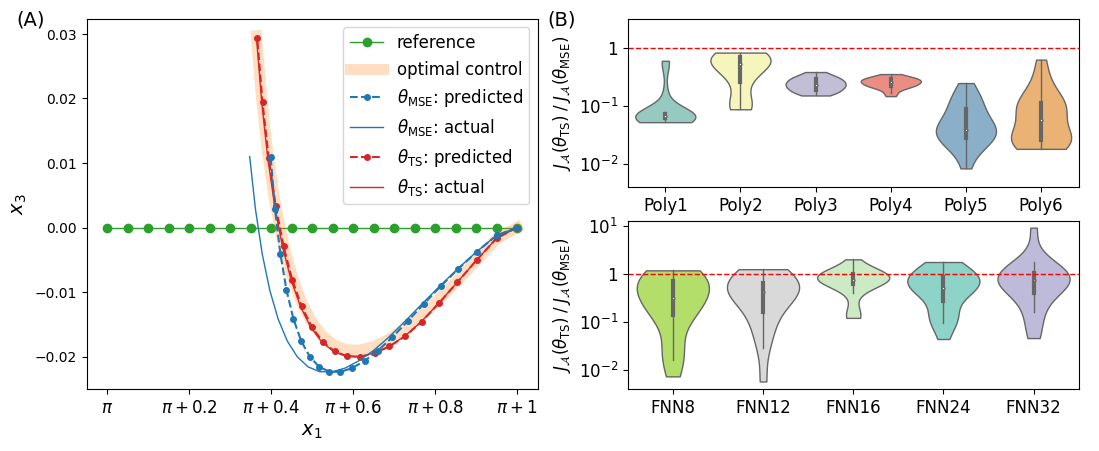

In [20]:
fig = plt.figure(figsize=(6.4*2, 4.8)) 
ax1 = plt.subplot(1, 2, 1)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plotx1(x, line, **kwargs):
    plt.plot(x[0, :, 0] - np.pi, x[0, :, 2], line, **kwargs)

plotx1(x_tracking, '-o',  linewidth=1.0, color=default_colors[2], label=r'reference')
plotx1(x_best_true, '-',  linewidth=8.0, alpha=0.25, color=default_colors[1], label=r'optimal control')

plotx1(x_pred_mse, 'o--',  markersize=4.0, color=(default_colors[0]), label=r'$\theta_{\mathrm{MSE}}$: predicted', zorder=20)
plotx1(x_model_mse, '-', linewidth=1.0, color=default_colors[0], label=r'$\theta_{\mathrm{MSE}}$: actual', zorder=20)
plotx1(x_pred_ts, 'o--',  markersize=4.0, color=(default_colors[3]), label=r'$\theta_{\mathrm{TS}}$: predicted')
plotx1(x_model_ts, '-', linewidth=1.0, color=default_colors[3], label=r'$\theta_{\mathrm{TS}}$: actual')
plt.xlabel(r'$x_1$', fontsize=14); plt.ylabel(r'$x_3$', fontsize=14)

xtixks = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(xtixks, [fr"$\pi+{tick}$" if tick != 0 else fr"$\pi$" for tick in xtixks], fontsize=12)
plt.legend(fontsize=12)


##
s = slice(0, 6, 1)
ax3 = plt.subplot(2, 2, 2)
err_ts, err_mse = res_arr[1,s], res_arr[0,s]

df = pandas.DataFrame(np.log10(err_ts/err_mse).T, columns=[f"Poly{val+1}" if val < 6 else f"FNN{val}" for val in nodess[s]])
sns.violinplot(data=df, bw_adjust=.5, cut=0, linewidth=1, palette="Set3",
    scale="width",
    width=0.8)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.ylabel(r'$J_{\mathcal{A}}(\theta_{\mathrm{TS}}) \;/\; J_{\mathcal{A}}(\theta_{\mathrm{MSE}})$', fontsize=12)

log_ticks = [-2, -1, 0,]
plt.ylim([-2.4, 0.5])

plt.yticks(log_ticks, [fr"$10^{{{tick}}}$" if tick != 0 else "1" for tick in log_ticks])
plt.tick_params(axis='both', which='major', labelsize=12)

##
ax4 = plt.subplot(2, 2, 4)
err_ts, err_mse = res_arr[1,6:], res_arr[0,6:]

df = pandas.DataFrame(np.log10(err_ts/err_mse).T, columns=[f"Poly{val+1}" if val < 6 else f"FNN{val}" for val in nodess[6:]])
sns.violinplot(data=df, bw_adjust=.5, cut=0, linewidth=1, palette="Set3",
    scale="width",
    width=0.8)

colors = sns.color_palette("Set3", 20)

for i, violin in enumerate(ax4.collections):
    violin.set_facecolor((*colors[i+6], 1.0))

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.ylabel(r'$J_{\mathcal{A}}(\theta_{\mathrm{TS}}) \;/\; J_{\mathcal{A}}(\theta_{\mathrm{MSE}})$', fontsize=12)

log_ticks = [-2, -1, 0, 1]
plt.ylim([-2.4, 1.1])

plt.yticks(log_ticks, [fr"$10^{{{tick}}}$" if tick != 0 else "1" for tick in log_ticks])
plt.tick_params(axis='both', which='major', labelsize=12)

big_ax = fig.add_subplot(111, frameon=False)  
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

for label, x0, y1 in zip(['(A)', '(B)'], [0.07, 0.485], [0.86, 0.86]):
    big_ax.text(x0, y1, f'{label}',
                transform=fig.transFigure,
                fontsize=14, ha='left', va='bottom')

plt.savefig(find_project_root() + "/examples/fig/Eg2.pdf", format="pdf", bbox_inches="tight")
plt.show();                                                                                                  #